# Time to get your hands dirty! Supernova distances and redshifts (part 2)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)


(35.0, 50.0)

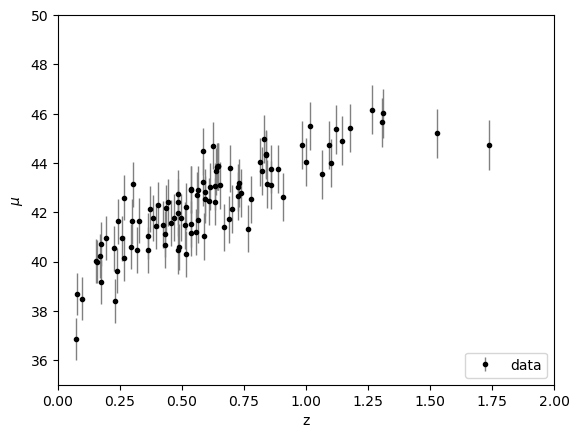

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [54]:
# sklearn format

X = z_sample[:,np.newaxis]
print(X.shape)

y = mu_sample 
print(y.shape)

dy = dmu 
print(dy.shape)

(100, 1)
(100,)
(100,)


### Gaussian Process Regression (GPR)

Gaussian Process Regression is a non-parametric, Bayesian approach to regression. Instead of assuming a fixed form for the function $f(x)$, GPR assumes that the function values are random variables drawn from a multivariate Gaussian distribution, fully specified by a mean function and a covariance function (also called a kernel).

“I don’t know what the function looks like — but I’ll assume that it’s a sample from a multivariate Gaussian distribution, where values that are ‘close’ in input space behave similarly.”

You’re standing in front of a foggy mountain. You can't see the whole shape, but you have a few altitude measurements at certain locations (data points). Now you want to guess:

“What does the rest of the mountain look like?”

But instead of drawing one fixed curve, you want to consider all possible mountain shapes that:
- Match the points you already know,
- Look reasonably smooth.

This is what Gaussian Process Regression does:
It gives you a whole family of smooth, plausible functions, and tells you:
- The most likely shape (the mean),
- How unsure it is at each point (the variance or confidence).


You give it some data: inputs $X$ and outputs $y$. Then:

- GPR computes the distribution over all possible functions that could have generated this data — weighted by how well they match the observations.

For any new input $x_∗$​, GPR gives a prediction:

- A mean value $μ_∗$: the most likely function value at $x_*$​.

- A variance $σ_∗^2$: how uncertain we are at $x_*$​.

- The prediction is more confident near the training data and less confident far away.


In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space. 

We define a Gaussian process: $f(x)\sim\mathcal{GP}(\mu(x),k(x,x'))$

where:
- $\mu(x)=\mathbb{E}[f(x)]$ is the mean function (often assumed to be 0)
- $k(x,x')= \mathbb{E}[(f(x)-\mu(x))(f(x')-\mu(x'))]$ is the covariance function, or **kernel**.

This means that for any finite set of inputs $X={x_1,...,x_n}$ the outputs 
$f(X)=[f(x_1),...f(x_n)]^T$ are jointly gaussian:

$$f(X)\sim\mathcal{N}(\mu(X),K(X,X))$$

where $K$ is the kernel matrix with entries $K_{ij}=k(x_i,x_j)$.

Suppose we observe training data $D={(X,y)}$ where $y=f(X)+\epsilon$, $\epsilon\sim\mathcal{N}(0,\sigma_n^2I)$

i.e., the observations are noisy versions of the latent function.

We want to predict the function value $f_∗$​ at a new input $x_*$​. The joint distribution of observed values $y$ and predicted values $f_∗$​ is:
$$
\begin{bmatrix}
y \\
f_*
\end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix}
m(X) \\
m(x_*)
\end{bmatrix},
\begin{bmatrix}
K(X,X) + \sigma_n^2 I & K(X,x_*) \\
K(x_*,X) & K(x_*,x_*)
\end{bmatrix}
\right)
$$

Conditioning on the observed data $y$, the posterior predictive distribution for $f_*$ is:

$$
f_* \mid x_*, X, y \sim \mathcal{N}(\mu_*, \sigma_*^2),
$$

with:

$$
\mu_* = K(x_*, X) \left[ K(X, X) + \sigma_n^2 I \right]^{-1} y,
$$

$$
\sigma_*^2 = K(x_*, x_*) - K(x_*, X) \left[ K(X, X) + \sigma_n^2 I \right]^{-1} K(X, x_*).
$$

This formulation gives not only a prediction $\mu_*$, but also a confidence estimate $\sigma_* $, which naturally increases for inputs farther from the training data.

Kernel Choice

The kernel function $k(x, x')$ encodes assumptions about the structure of the function being learned (e.g., smoothness, periodicity). Common choices include:


**RBF (Squared Exponential) Kernel**:
$$
k(x, x') = \sigma_f^2 \exp\left( -\frac{(x - x')^2}{2\ell^2} \right)
$$
where $\mathcal{l}$ is the length scale (controls how quickly the function varies),

$σ_f^2$​ is the signal variance (controls output amplitude),
$||x−x'||^2$ is the squared Euclidean distance between inputs $x$ and $x'$.

**Matérn Kernels:**
Flexible kernels with an additional smoothness parameter $\nu$, e.g., Matérn-$\frac{3}{2}$ or Matérn-$\frac{5}{2}$.

**Linear, Periodic, or Composite Kernels:**
These can model trend, seasonality, and more complex behaviors by combining basic kernels.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Define the RBF kernel
# -----------------------------
def rbf_kernel(X1, X2, length_scale=0.5, sigma_f=1.0):
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + \
             np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# -----------------------------
# GP regression
# -----------------------------
def gp_predict(X_train, y_train, X_pred, noise_var=1e-4, length_scale=0.5, sigma_f=1.0):
    K = rbf_kernel(X_train, X_train, length_scale, sigma_f)
    K += noise_var * np.eye(len(X_train))  # Add noise

    K_s = rbf_kernel(X_train, X_pred)
    K_ss = rbf_kernel(X_pred, X_pred)

    K_inv = np.linalg.inv(K)
    mu = K_s.T @ K_inv @ y_train
    cov = K_ss - K_s.T @ K_inv @ K_s
    return mu, np.sqrt(np.diag(cov))




In [13]:
X_pred = np.linspace(X.min() - 0.1, X.max() + 0.1, 500).reshape(-1, 1)
# Estimate noise from dy
noise_var = np.mean(dy)**2

print(rbf_kernel(X, X,length_scale=0.5, sigma_f=1.0))
print('\n')
print(rbf_kernel(X, X_pred,length_scale=0.5, sigma_f=1.0))
print('\n')
print(rbf_kernel(X_pred, X_pred,length_scale=0.5, sigma_f=1.0))

[[1.         0.79195963 0.93362224 ... 0.50212844 0.9681692  0.73868933]
 [0.79195963 1.         0.95238338 ... 0.88652989 0.64447558 0.99546901]
 [0.93362224 0.95238338 1.         ... 0.72430825 0.82258481 0.92026041]
 ...
 [0.50212844 0.88652989 0.72430825 ... 1.         0.36066359 0.92477242]
 [0.9681692  0.64447558 0.82258481 ... 0.36066359 1.         0.58672909]
 [0.73868933 0.99546901 0.92026041 ... 0.92477242 0.58672909 1.        ]]


[[0.8089259  0.81284842 0.81674437 ... 0.00921137 0.00900281 0.00879848]
 [0.41062255 0.41472447 0.41884399 ... 0.0590513  0.05800951 0.05698291]
 [0.59327602 0.59780584 0.60233662 ... 0.02675046 0.02621727 0.02569328]
 ...
 [0.18912355 0.19171447 0.19433004 ... 0.16825368 0.16589248 0.16355529]
 [0.924268   0.92698663 0.92966137 ... 0.0040931  0.00399283 0.0038948 ]
 [0.3599546  0.3638093  0.36768477 ... 0.0737419  0.07249253 0.07126034]]


[[1.00000000e+00 9.99972093e-01 9.99888378e-01 ... 1.01456935e-03
  9.86784821e-04 9.59707624e-04]
 [9.99972

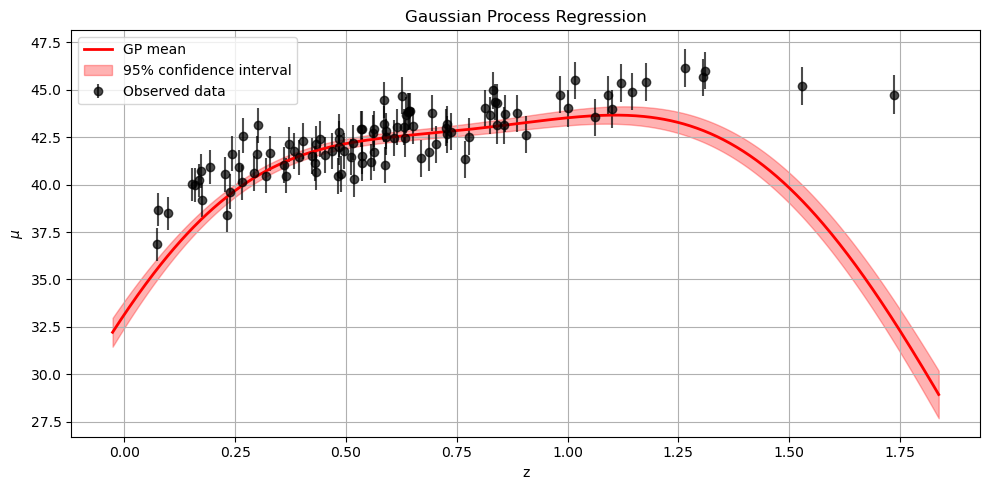

In [23]:
# GP prediction
mu_pred, std_pred = gp_predict(X, y, X_pred, noise_var=noise_var, length_scale=0.5, sigma_f=1)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 5))

# Original data
plt.errorbar(X.ravel(), y, yerr=dy, fmt='o', color='black', label='Observed data', alpha=0.7)

# GP mean and confidence interval
plt.plot(X_pred, mu_pred, 'r-', lw=2, label='GP mean')
plt.fill_between(
    X_pred.ravel(),
    mu_pred - 2 * std_pred,
    mu_pred + 2 * std_pred,
    color='red',
    alpha=0.3,
    label='95% confidence interval'
)

plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.title('Gaussian Process Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


(35.0, 50.0)

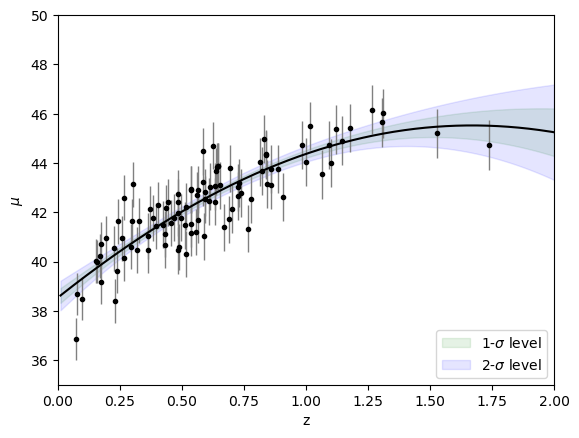

In [29]:


from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor


#kernel = ConstantKernel(1.0, (1e-1, 1e1)) * RBF(1, (1e-1, 1e1))
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=dmu ** 2)


z = np.linspace(0.01, 2, 1000)


gp.fit(z_sample[:, None], mu_sample)
mu_fit, sigma = gp.predict(z[:, None], 
                           return_std=True)

mu_fit = gp.predict(z[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.plot(z, mu_fit, '-k')

plt.fill_between(z, mu_fit - sigma, 
                mu_fit + sigma,
                alpha=0.1, color='g', 
                label='1-$\sigma$ level')

plt.fill_between(z, mu_fit - 2* sigma, 
                mu_fit + 2* sigma,
                alpha=0.1, color='b', 
                label='2-$\sigma$ level')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)



### Fitting a PARAMETRIC model

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 


In [55]:
from astropy.cosmology import LambdaCDM

# computes model according to the above expression
def generativemodel(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value #note I added .value here. Astropy units can be funny.

## Just checking it works
generativemodel(np.random.uniform(0,2,10), 50, 0.1)

array([45.18724539, 43.85869418, 46.09975298, 45.76922474, 46.45125412,
       45.82777226, 42.11092372, 42.41300728, 46.26711956, 40.16864396])

### Fit with LM algorithm

In [20]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(
    generativemodel,
    z_sample,
    mu_sample,
    sigma=dmu,
    absolute_sigma=True,
    p0=[70, 0.3],       # initial guess: H0=70, Om=0.3
    method='lm'         # explicitly use LM
)

H0_fit, Om_fit = popt
print(f"Best-fit H0: {H0_fit:.2f}")
print(f"Best-fit Omega_m: {Om_fit:.3f}")

Best-fit H0: 68.52
Best-fit Omega_m: 0.345


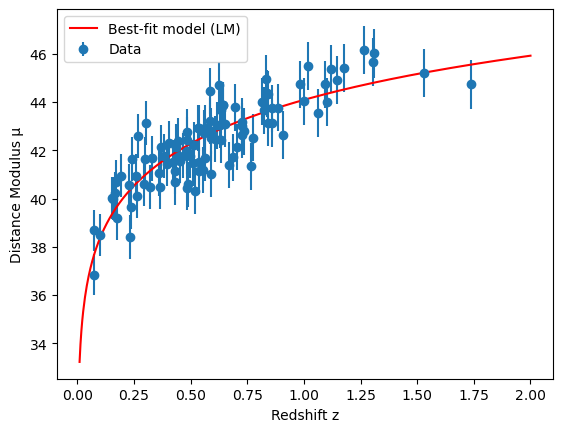

In [21]:
z_grid = np.linspace(0.01, 2, 500)
mu_fit = generativemodel(z_grid, *popt)

plt.errorbar(z_sample, mu_sample, yerr=dmu, fmt='o', label='Data')
plt.plot(z_grid, mu_fit, label='Best-fit model (LM)', color='red')
plt.xlabel("Redshift z")
plt.ylabel("Distance Modulus μ")
plt.legend()
plt.show()

### Bayesian way, fit with MCMC 

In [22]:
import emcee
import scipy.stats as scistats
import corner
import dynesty


In [60]:
# I take my likelihood to be gaussian. Good thing to do if you don't know anything else (like in this case, I didn't tell you otherwise).
# In a flat universe two parameters are enough to describe the cosmology: H0, the Hubble expansion rate today, and Omega_m, the matter content 
# Omega_Lambda + Omega_m = 1

def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample, H0, Om)
    
    #return np.sum(scistats.norm.logpdf(mu_sample, loc=mu_model, scale=dmu))
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

In [61]:
def Logprior(theta):
    Om,H0 = theta
    if 50 < H0 < 100 and 0.1 < Om < 1:
        return 0.0
    return -np.inf

def LogPosterior(theta):
    return LogLikelihood(theta) + Logprior(theta)



In [62]:
ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nsteps = int(1e4)  # number of MCMC steps to take **for each walker**

# First parameter is O_m, the second is H0
starting_guesses = np.array([0.5,80]) + 1e-1* np.random.randn(nwalkers, ndim)

print(starting_guesses.shape)
print(starting_guesses)

(5, 2)
[[ 0.49550556 80.04974016]
 [ 0.58194536 79.97165045]
 [ 0.35094752 79.92410646]
 [ 0.48492413 80.00057428]
 [ 0.51593972 79.968706  ]]


In [29]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps)

print("done")


done


In [30]:
samples = sampler.get_chain()

In [31]:
tau = sampler.get_autocorr_time()
print(tau)


[46.95286018 49.43786289]


In [32]:
samples.shape


(10000, 5, 2)

In [33]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)


(1005, 2)


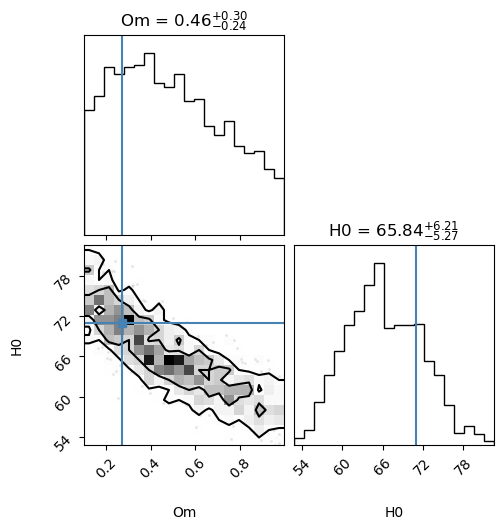

In [62]:

fig = corner.corner(
    flat_samples, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);



(35.0, 50.0)

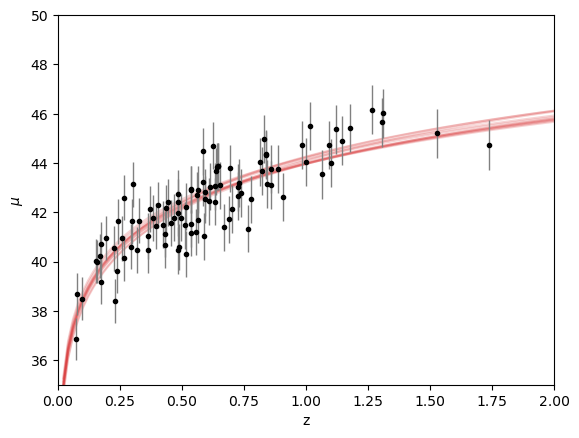

In [36]:
zlin = np.linspace(0,2,100)[1:]
for Om,H0, in flat_samples[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    



In [63]:

ndims  =2 

def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    mins = np.array([0.1,30])
    maxs = np.array([1,100])
        
    return  mins + u*(maxs-mins)


In [64]:


# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim,nlive=1000)
sampler.run_nested()
sresults = sampler.results



2710it [00:14, 184.08it/s, +1000 | bound: 0 | nc: 1 | ncall: 17544 | eff(%): 22.425 | loglstar:   -inf < -132.813 <    inf | logz: -135.236 +/-  0.019 | dlogz:  0.001 >  1.009]


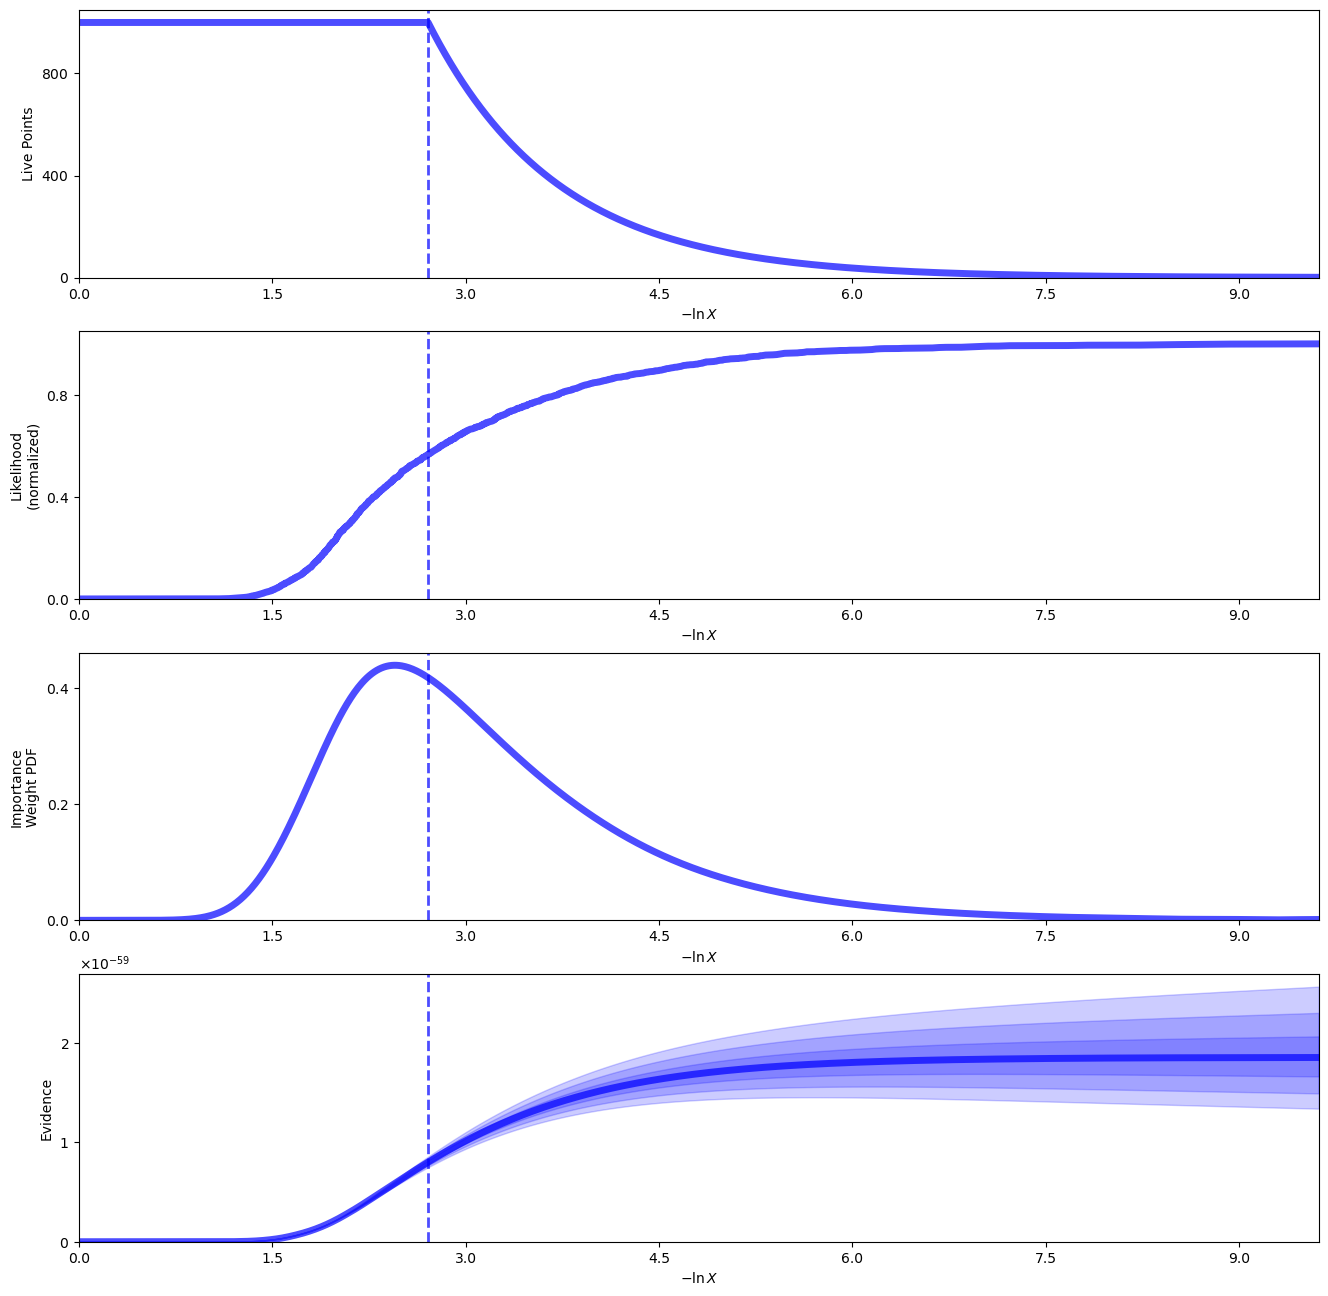

In [65]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)



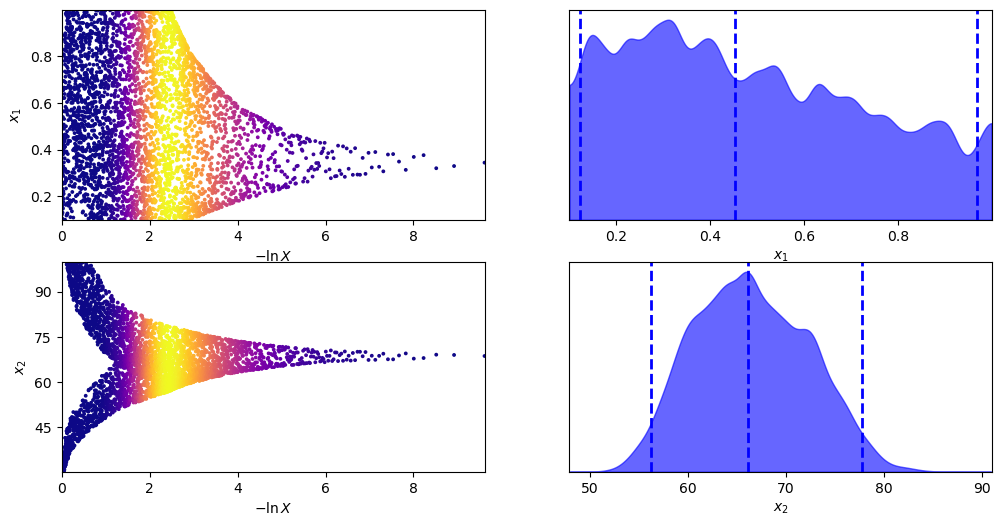

In [66]:


tfig, taxes = dyplot.traceplot(sresults)



In [67]:


from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.resample_run(sresults)



68% parameter credible regions are:
 [[0.21894080064551805, 0.7755975861640442], [60.30436487261089, 72.72976542387006]]

Mean and covariance of parameters are: [ 0.48470313 66.44382118]
[[ 0.0602695  -1.20874645]
 [-1.20874645 33.25751389]]


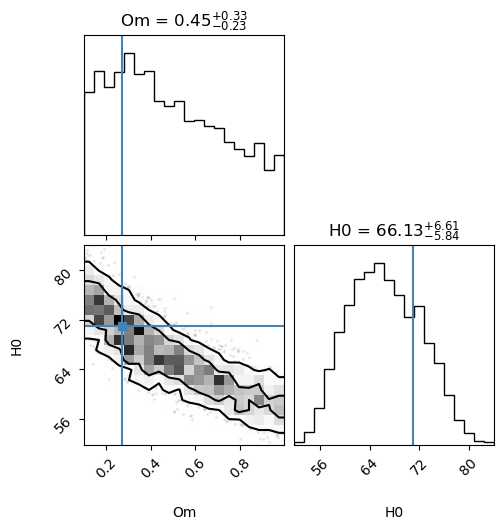

In [68]:
fig = corner.corner(
    samples_equal, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

(35.0, 50.0)

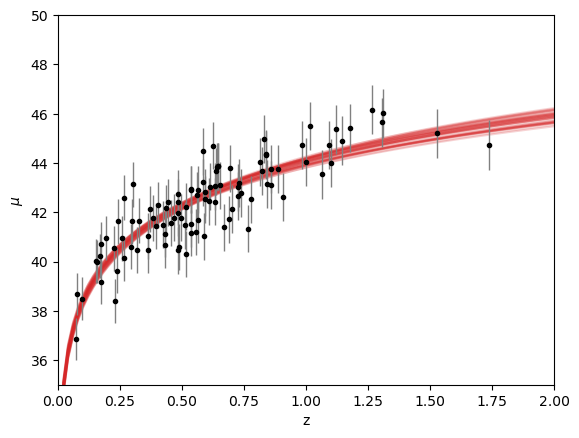

In [69]:
for Om,H0, in samples_equal[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

# Do we need dark energy ?


In [37]:

def LogLikelihood_mod(theta):

    H0 = float(theta)    
    Om=1
    mu_model = generativemodel(z_sample, H0, Om)
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

ndim  =1

def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    mins = np.array([30.])
    maxs = np.array([100.])
        
    return  mins + u*(maxs-mins)

In [38]:
import emcee
import scipy.stats as scistats
import corner
import dynesty

# "Static" nested sampling.
sampler_mod = dynesty.NestedSampler(LogLikelihood_mod, ptform, ndim,nlive=1000)
sampler_mod.run_nested()
sresults_mod = sampler_mod.results


/tmp/ipykernel_7787/4238609091.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  H0 = float(theta)
2834it [00:14, 197.23it/s, +1000 | bound: 0 | nc: 1 | ncall: 17175 | eff(%): 23.703 | loglstar:   -inf < -133.530 <    inf | logz: -135.984 +/-    nan | dlogz:  0.001 >  1.009]


In [39]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults_mod.samples  # samples
weights = np.exp(sresults_mod.logwt - sresults_mod.logz[-1])  # normalized weights

# Resample weighted samples.
samples_equal_mod = dyfunc.resample_equal(samples, weights)

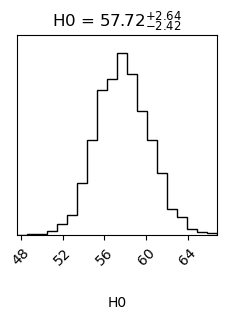

In [40]:
fig = corner.corner(
    samples_equal_mod, labels=["H0"], levels=[0.68,0.95], show_titles=True) #truths=[71]




/tmp/ipykernel_7787/28052371.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(zlin, generativemodel(zlin, float(H0), 1),c='C3',alpha=0.2)


(35.0, 50.0)

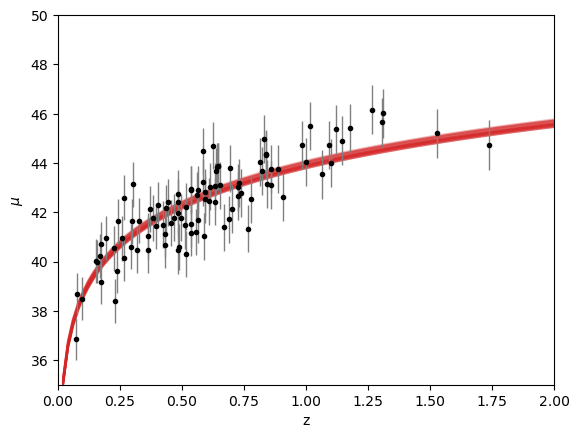

In [41]:
for H0 in samples_equal_mod[::100]:
    plt.plot(zlin, generativemodel(zlin, float(H0), 1),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Do we really need dark energy? Let's compare bayesian evidences.

In [70]:
np.exp(sampler.results.logz[-1])/np.exp(sampler_mod.results.logz[-1])

2.1129291344201855

Indeed, the Bayes factor is inconclusive. **With this data**, we can't really tell if we live in a Universe without dark energy and $H_0\sim 60$ or in a Universe with $H_0\sim 70$ and 70\% of dark energy.